In [9]:
!pip install scikit-learn xgboost


   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/8.9 MB 1.1 MB/s eta 0:00:08
    --------------------------------------- 0.2/8.9 MB 1.8 MB/s eta 0:00:05
   - -------------------------------------- 0.3/8.9 MB 2.1 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/8.9 MB 2.7 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/8.9 MB 2.5 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/8.9 MB 2.7 MB/s eta 0:00:04
   ---- ----------------------------------- 0.9/8.9 MB 2.7 MB/s eta 0:00:03
   ----- ---------------------------------- 1.2/8.9 MB 2.9 MB/s eta 0:00:03
   ------ --------------------------------- 1.4/8.9 MB 3.0 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.9 MB 3.2 MB/s eta 0:00:03
   -------- ------------------------------- 1.9/8.9 MB 3.5 MB/s eta 0:00:03
   --------- -------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vinic\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Arquivos CSV carregados com sucesso!
Amostras de Treino: 135830, Amostras de Teste: 2897

Classes (alvo) codificadas: ['Esfera', 'Normal', 'Pista Externa', 'Pista Interna']

Pré-processamento concluído: LabelEncoder e StandardScaler aplicados.

--- INICIANDO TREINAMENTO DOS MODELOS ---
Treinando QDA...
Treinando XGBoost...


C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [16:41:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- TREINAMENTO CONCLUÍDO ---

--- AVALIAÇÃO DOS MODELOS NO CONJUNTO DE TESTE ---

  Resultados para o modelo: QDA
Acurácia: 0.3573 (ou 35.73%)

Relatório de Classificação:
               precision    recall  f1-score   support

       Esfera       0.00      0.00      0.00       997
       Normal       0.00      0.00      0.00       115
Pista Externa       0.00      0.00      0.00       750
Pista Interna       0.37      1.00      0.54      1035

     accuracy                           0.36      2897
    macro avg       0.09      0.25      0.14      2897
 weighted avg       0.13      0.36      0.19      2897

Matriz de Confusão:


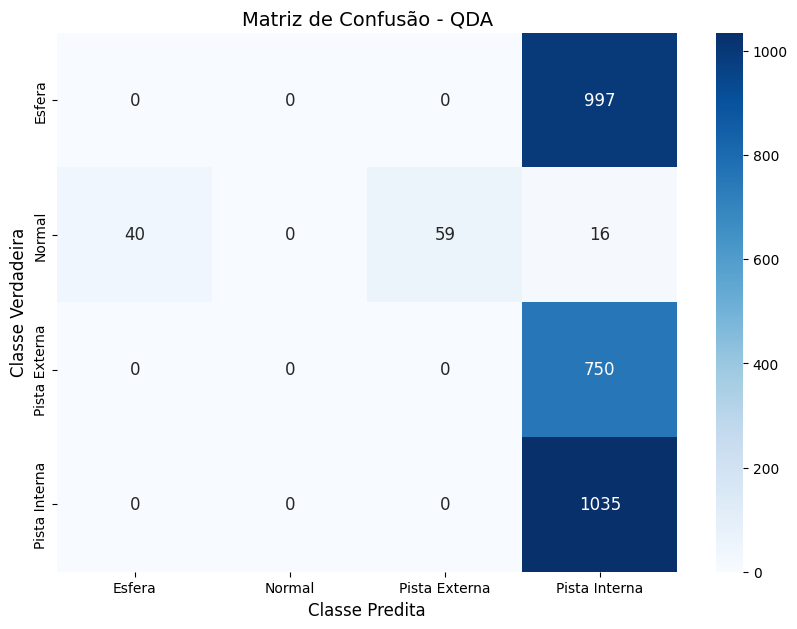


  Resultados para o modelo: XGBoost
Acurácia: 0.3573 (ou 35.73%)

Relatório de Classificação:
               precision    recall  f1-score   support

       Esfera       0.00      0.00      0.00       997
       Normal       0.00      0.00      0.00       115
Pista Externa       0.00      0.00      0.00       750
Pista Interna       0.36      1.00      0.53      1035

     accuracy                           0.36      2897
    macro avg       0.09      0.25      0.13      2897
 weighted avg       0.13      0.36      0.19      2897

Matriz de Confusão:


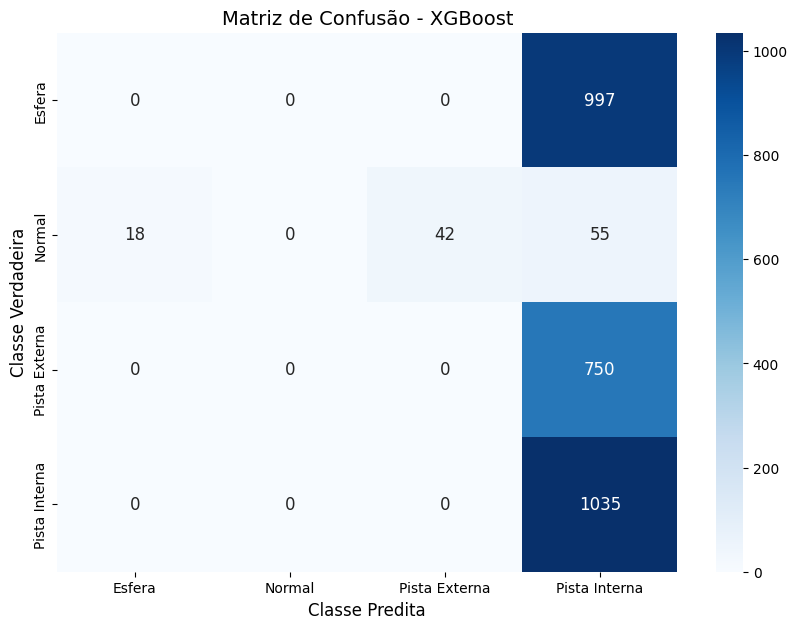

In [1]:
# =============================================================================
# BLOCO 5: TREINAMENTO E AVALIAÇÃO DOS MODELOS (QDA, SVM, XGBOOST)
# =============================================================================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. CARREGAR OS DADOS ---

# Caminho onde os CSVs foram salvos (ajuste se for diferente)
caminho_base_output = r'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC'
caminho_csv_treino = os.path.join(caminho_base_output, 'df_treino_features.csv')
caminho_csv_teste = os.path.join(caminho_base_output, 'df_teste_features.csv')

try:
    df_treino = pd.read_csv(caminho_csv_treino)
    df_teste = pd.read_csv(caminho_csv_teste)
    print("Arquivos CSV carregados com sucesso!")
    print(f"Amostras de Treino: {len(df_treino)}, Amostras de Teste: {len(df_teste)}")
except FileNotFoundError:
    print(f"ERRO: Arquivos CSV não encontrados no caminho: {caminho_base_output}")
    print("Verifique se o Bloco 4 foi executado e os arquivos estão no local correto.")
    # Se der erro aqui, não continue o script
    raise

# --- 2. PREPARAÇÃO DOS DADOS (PRÉ-PROCESSAMENTO) ---

# Definir colunas de features e a coluna alvo
# (Baseado na saída do Bloco 3)
feature_columns = [
    'TF2_std', 'TF3_rms', 'TF4_fator_forma',
    'FF2_freq_central', 'FF3_rms_freq', 'FF5_assimetria_espectral',
    'FF_pico_50_200Hz'
]
target_column = 'tipo_falha_adicionada'

# Separar X (features) e y (alvo)
X_treino = df_treino[feature_columns]
y_treino = df_treino[target_column]

X_teste = df_teste[feature_columns]
y_teste = df_teste[target_column]

# --- 2a. Label Encoding (para a variável alvo 'y') ---
# Modelos precisam de alvos numéricos (ex: 0, 1, 2) em vez de ('Normal', 'Esfera', ...)
le = LabelEncoder()
y_treino_encoded = le.fit_transform(y_treino)
y_teste_encoded = le.transform(y_teste) # Usa o 'transform' para garantir a mesma ordem

# Salvar os nomes das classes para os relatórios
class_names = le.classes_
print(f"\nClasses (alvo) codificadas: {list(class_names)}")

# --- 2b. Feature Scaling (para as features 'X') ---
# (Importante para SVM e QDA)
scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled = scaler.transform(X_teste) # Apenas 'transform' no teste (evita data leakage)

print("\nPré-processamento concluído: LabelEncoder e StandardScaler aplicados.")

# --- 3. DEFINIÇÃO E TREINAMENTO DOS MODELOS ---

# Dicionário com os modelos a serem treinados
models = {
    'QDA': QuadraticDiscriminantAnalysis(),
    #'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Dicionário para armazenar os modelos treinados
trained_models = {}

print("\n--- INICIANDO TREINAMENTO DOS MODELOS ---")
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_treino_scaled, y_treino_encoded)
    trained_models[name] = model
print("--- TREINAMENTO CONCLUÍDO ---")

# --- 4. AVALIAÇÃO DOS MODELOS NO CONJUNTO DE TESTE ---

print("\n--- AVALIAÇÃO DOS MODELOS NO CONJUNTO DE TESTE ---")

for name, model in trained_models.items():
    # Fazer predições no conjunto de teste
    y_pred = model.predict(X_teste_scaled)
    
    # Calcular Acurácia
    accuracy = accuracy_score(y_teste_encoded, y_pred)
    
    print(f"\n=======================================================")
    print(f"  Resultados para o modelo: {name}")
    print(f"=======================================================")
    print(f"Acurácia: {accuracy:.4f} (ou {accuracy*100:.2f}%)")
    
    # Exibir Relatório de Classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_teste_encoded, y_pred, target_names=class_names, zero_division=0))
    
    # Exibir Matriz de Confusão
    print("Matriz de Confusão:")
    cm = confusion_matrix(y_teste_encoded, y_pred)
    
    # Plotar a Matriz de Confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}) # Aumenta o tamanho da fonte
    plt.xlabel('Classe Predita', fontsize=12)
    plt.ylabel('Classe Verdadeira', fontsize=12)
    plt.title(f'Matriz de Confusão - {name}', fontsize=14)
    plt.show()